# Cours d'introduction à la technologie Chipwhisperer 

## *Differential Power Analysis* : les choses se corsent

Jusqu'ici nous avons vu que la consommation électrique dépend fortement des opérations réalisées, mais cela va plus loin : elle dépend aussi des données manipulées par le système ! Ainsi, un bit traité par le système ne produira pas la même trace de consommation selon qu'il soit à 0 ou à 1. Cette corrélation ouvre donc évidemment la porte à de nombreuses possibilités d'attaque ! Cependant, la différence que l'on peut mesurer entre 2 traces est infime, c'est pourquoi cette attaque nécessite un grand nombre de traces recueillies.

Pour rappel, la *Differential Power Analysis* est une technique exploitant la dépendance entre la consommation d’énergie des dispositifs cryptographiques et les données traitées. L'attaque se déroule en 5 étapes : 
  1. Choisir un résultat intermédiaire de l'algorithme attaqué (ATTENTION : nécessite que toutes les traces soient alignées, voir Annexe)
  2. Recueillir un nombre suffisant de traces de consommation électrique
  3. Calculer les valeurs intermédiaires hypothétiques (i.e pour toutes les valeurs de clé possibles)
  4. Faire correspondre ces valeurs avec les valeurs hypothétiques de consommation électrique associées (choisir un **modèle de consommation**)
  5. Séparer les valeurs intermédiaires hypothétiques obtenues en 3. en deux groupes selon une hypothèse sur un bit particulier (G_0 pour bit à 0, et G_1 pour bit à 1)
  6. Calculer la moyenne des valeurs de consommation pour chaque groupe (obtenues en 4.)
  7. La bonne hypothèse de clé est celle qui fait ressortir la plus grande différence entre les 2 moyennes obtenues.

Explicitons tout cela. Le résultat intermédiaire à attaquer est appelé "point d'intérêt", ou **Point of Interest**, et correspond aux instants où le système effectue une opération intermédiaire de l'algorithme cryptographique utilisé **dépendant de la clé** (souvent l’entrée ou la sortie d’un S-Box dans AES, etc...). \
L'étape 3 consiste, pour chaque octet de la clé, énumérer toutes les valeurs possibles de celui-ci (0…255 pour un octet).
Pour chaque valeur k_candidate et chaque trace T_i, calculer la **valeur intermédiaire V_i(k_candidate) correspondant au point d'intérêt** choisi précédemment (par exemple S-Box[message_i ⊕ k_candidate]). \
Ensuite, pour chaque valeur intermédiaire obtenue, on détermine à l'aide du modèle de consommation choisi (exemples : Hamming Weigth, Hamming Distance, etc...) la **consommation électrique qu'aurait produit cette valeur** si elle avait été calculée par le système lui-même. \
C'est ici qu'intervient notre hypothèse clée selon laquelle la consommation est corrélée aux données manipulées. En effet, on va séparer les valeurs intermédiaires hypothétiques calculées à l'étape 3. en 2 groupes en fonction de la valeur d'un bit quelconque (soit 0, soit 1). On va ensuite calculer la moyenne des valeurs de consommation pour chacun des deux groupes, et étudier la différence entre ces moyennes. La bonne hypothèse de clé sera le **maximum de cette différence**. Pourquoi cela ? 

Le système consomme légèrement plus (ou moins) lorsqu’il manipule certaines valeurs internes en fonction de leur nature : par exemple, un poids de Hamming élevé implique une consommation électrique plus élevée, etc... c'est l'illustration en pratique de la corrélation données/consommation dont on parle depuis le début de ce lab. \
Ainsi, si on devine la bonne valeur de clé, alors le découpage des traces en groupes « bit = 1 » et « bit = 0 » **reflète clairement ce changement de consommation** en fonction de la valeur du bit : les moyennes de chaque groupe  s’écarteront nettement l’une de l’autre à l’instant précis où l'opération du point d'intérêt à lieu, créant un pic maximal. Au contraire, pour une mauvaise hypothèse de clé, la **répartition des traces est aléatoire** vis-à-vis de la consommation électrique et les deux moyennes restent très proches !

### Pour les sceptiques : différences de poids de Hamming 

Nous allons commencer par prouver de manière visuelle la corrélation entre la nature des données manipulées et la trace de consommation associée. D'abord, on recueille un grand nombre de traces de consommation : puisque nous travaillons sur un cas simple, nous disposons ici de 100 traces.

In [2]:
from cwtraces import sca101_lab_data
import numpy as np
import chipwhisperer as cw

data = sca101_lab_data["lab3_1"]()
trace_array =  data["trace_array"]
textin_array = data["textin_array"]

assert len(trace_array) == 100
print("✔️ OK to continue!")

✔️ OK to continue!


Ce set de données est légèrement faussé à des fins pédagogiques : en effet, la valeur du 1er octet du texte clair envoyé au système a été forcé aléatoirement à `0x00` ou `0xFF`, c'est-à-dire à des valeurs possédant des poids de Hamming les plus opposés possibles afin de mettre en évidence la différence de consommation que cela engendre. \
Maintenant, séparons-les en 2 groupes en fonction de la valeur du 1er octet, `0x00`ou `0xFF`.

In [3]:
zero_list = []
one_list = []

for i in range(len(trace_array)):
    if textin_array[i][0] == 0x00:
        zero_list.append(trace_array[i])
    else:
        one_list.append(trace_array[i])

Maintenant, prenons la valeur moyenne de trace de chacun des deux groupes, autrement dit faisons la moyenne à chaque point de toutes les traces de chaque groupe (`axis=0` pour `np.mean()`).

In [4]:
one_avg: float = np.mean(one_list, axis=0)
zero_avg: float = np.mean(zero_list, axis=0)

Il ne nous reste plus qu'à tracer la courbe de la différence entre les moyennes de chaque groupe :

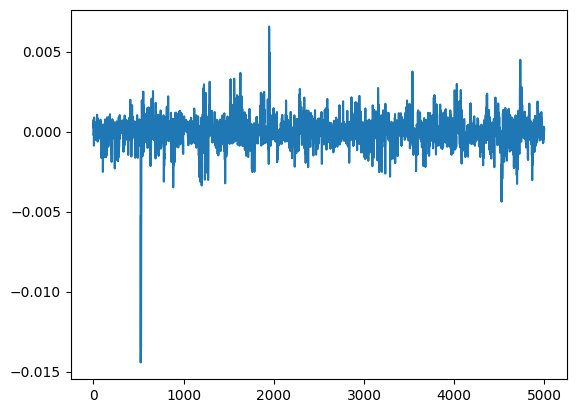

In [5]:
import matplotlib.pyplot as plt

diff = one_avg - zero_avg

plt.plot(diff)
plt.show()

On observe un pic clairement visible au début du tracé : cela signifie que la différence des moyennes des valeurs de consommation est très élevée en un point, correspondant à l'octet modifié au début du lab. Ainsi, cela prouve que les données manipulées par le système cible sont visibles dans ses traces de consommation ! 

## DPA sur AES : pour commencer en douceur

Commençons par nous entraîner à retrouver des informations sur la clé secrète utilisée AES à partir des données manipulées. Premièrement, il nous faut choisir un point d'intérêt : la sortie de la `S-Box`. Les données recueillies ont donc subi un XOR avec la clé secrète, puis sont passées à travers la `S-Box` que nous modéliserons par un tableau. Voici ci-dessous les outils dont nous aurons besoin : 

In [7]:
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

# performs a XOR between the input data and the secret key, then passes the result through the S-Box 
def aes_internal(inputdata, key):
    return sbox[inputdata ^ key]

Dans cette partie, nous allons par souci de simplicité forcer la valeur de la clé secrète AES utilisée et voir comment il nous est possible de récupérer sa valeur par la suite.

In [9]:
# performs the AES operations detailed previously with '0xEF' as the secret key value
def aes_secret(inputdata):
    secret_key = 0xEF
    return aes_internal(secret_key, inputdata)

Pour les débutants que nous sommes, nous allons commencer par observer seulement un bit des données manipulées par AES. Nous allons donc envoyer des données random à traiter à l'algorithme, puis observer un bit (par exemple le plus bas) des données en sortie, puis comme précédemment les séparer en deux groupes en fonction de la valeur du bit observé.

In [11]:
import random

# random data fed to the AES algorithm part we observe
input_data = [random.randint(0, 255) for _ in range(1000)]

# value of the lowest bit of the input data passed through the XOR and the S-Box
leaked_data = [(aes_secret(a) & 0x01) for a in input_data]

On rappelle le principe de notre attaque : Pour chaque valeur possible de la clé, on simule le chiffrement et on compare le résultat simulé avec les données observées sur le vrai dispositif. Si, pour une clé candidate, la simulation produit exactement les mêmes valeurs que celles observées, cela signifie très probablement que cette clé est la bonne. Ainsi, il nous faut un moyen de comparer deux valeurs entre elle, et nous allons utiliser pour cela simplement une fonction qui compte combien de bits sont identiques.

In [12]:
def count_same(a,b):
    return len([a[i] for i in range(len(a)) if a[i] == b[i]])

Nous pouvons maintenant réaliser l'attaque en elle-même telle que décrite juste au dessus à l'aide d'une boucle `for`: 

In [14]:
key_guess: list = [i for i in range(256)]
for guess in range(0, 256):   
    
    #Get a hypothetical leakage list - use aes_internal(guess, input_byte) and mask off to only get value of lowest bit
    hypothetical_leakage = [(aes_internal(guess, input_byte) & 0x01) for input_byte in input_data]
    
    #Use our function of comparison
    same_count = count_same(hypothetical_leakage, leaked_data)   
    
    print("Guess {:02X}: {:4d} bits same".format(guess, same_count))

Guess 00:  459 bits same
Guess 01:  442 bits same
Guess 02:  464 bits same
Guess 03:  518 bits same
Guess 04:  454 bits same
Guess 05:  464 bits same
Guess 06:  501 bits same
Guess 07:  505 bits same
Guess 08:  465 bits same
Guess 09:  490 bits same
Guess 0A:  488 bits same
Guess 0B:  526 bits same
Guess 0C:  546 bits same
Guess 0D:  546 bits same
Guess 0E:  537 bits same
Guess 0F:  508 bits same
Guess 10:  497 bits same
Guess 11:  522 bits same
Guess 12:  427 bits same
Guess 13:  513 bits same
Guess 14:  498 bits same
Guess 15:  520 bits same
Guess 16:  489 bits same
Guess 17:  539 bits same
Guess 18:  510 bits same
Guess 19:  452 bits same
Guess 1A:  465 bits same
Guess 1B:  527 bits same
Guess 1C:  506 bits same
Guess 1D:  438 bits same
Guess 1E:  466 bits same
Guess 1F:  508 bits same
Guess 20:  501 bits same
Guess 21:  546 bits same
Guess 22:  461 bits same
Guess 23:  477 bits same
Guess 24:  525 bits same
Guess 25:  458 bits same
Guess 26:  583 bits same
Guess 27:  482 bits same


Puisqu'une seule valeur de clé est correcte, il est normal que toutes les autres produisent des valeurs à peu près uniformément réparties, et donc leur nombre de bits identiques associé est aux alentours de 1000/2 = 500, sauf pour la valeur correcte de clé : on observe bien que pour `0xEF`, le nombre de bits identiques vaut 1000. Ainsi, on a bien retrouvé la valeur de clé secrète utilisée !

## DPA sur AES : an oldie but a goodie

Nous allons maintenant implémenter une attaque DPA classique sur AES. Dans l'attaque précédente, nous utilisions une valeur de bit à 0 ou à 1, mais maintenant nous allons nous placer en situation réelle et effectuer une **analyse de puissance** afin de déterminer la valeur du bit observé. On commence par capturer un grand nombre de traces correspondant à des valeurs aléatoires envoyées au système.

In [15]:
from cwtraces import sca101_lab_data
import chipwhisperer as cw

data = sca101_lab_data["lab3_3"]()
trace_array =  data["trace_array"]
textin_array = data["textin_array"]

assert(len(trace_array) == 2500)
print("✔️ OK to continue!")

✔️ OK to continue!


Nous allons maintenant séparer comme habituellement nos traces en 2 groupes en fonction de la valeur d'un bit quelconque de notre 'guessed value'.

In [17]:
from rich import print

numtraces = np.shape(trace_array)[0] #total number of traces
numpoints = np.shape(trace_array)[1] #samples per trace
mean_diffs = np.zeros(256) # will contain the difference between the mean of each group for each possible key byte value
bytes_to_attack: int = 0

for key_bytes_guess_value in range(256): # for each possible key byte value
    one_list = []
    zero_list = []

    for trace_index in range(numtraces): 
        input_bytes = textin_array[trace_index][bytes_to_attack]

        hypothetical_leakage = aes_internal(key_bytes_guess_value, input_bytes) 

        # si le bit observé est un 1 
        if hypothetical_leakage & 0x01:
            one_list.append(trace_array[trace_index])
        else:
            zero_list.append(trace_array[trace_index])

    # moyenne pour chaque groupe
    zero_avg = np.mean(zero_list, axis=0)
    one_avg = np.mean(one_list, axis=0)

    max_diff_value = np.max(abs(one_avg - zero_avg))
    # on stocke la différence maximale entre les moyennes pour ce guess de valeur de clé secrète
    mean_diffs[key_bytes_guess_value] = max_diff_value

sorted_list = np.argsort(mean_diffs)[::-1]
#Print top 5 only
for guess in sorted_list[0:5]:
    print("Key Guess {:02X} = {:04f} matches".format(guess, mean_diffs[guess]))

print(f":information: First Bit ({hex(sorted_list[0])}): {mean_diffs[sorted_list[0]]} => Difference with the second: {mean_diffs[sorted_list[0]] - mean_diffs[sorted_list[1]]} ({hex(sorted_list[1])}: {mean_diffs[sorted_list[1]]})")

Key Guess 2B = 0.002540 matches

Key Guess 69 = 0.001297 matches

Key Guess 40 = 0.001297 matches

Key Guess 75 = 0.001285 matches

Key Guess 97 = 0.001263 matches

ℹ First Bit (0x2b): 0.002539628236491495 => Difference with the second: 0.0012428327863228117 (0x69: 
0.0012967954501686835)

Ainsi, on a retrouvé le premier octet de la clé secrète AES utilisée en utilisant la valeur d'un bit observé, valeur déterminée grâce à une analyse de puissance. Nous avons donc réalisé une attaque DPA sur AES ! Il est bien sûr possible d'étendre cette attaque à tous les octets de la clé secrète afin de la reconstituer dans sa totalité, simplement en englobant le code précédant dans une boucle `for bytes_to_attack in range(16):` afin de la répéter pour chaque octet.